# Stellar Mass Density Mosaic

Isaac Cheng - December 2021

Making a radial profile mosaic of the NGVS-VERTICO stellar mass densities.


In [1]:
SIG_STAR_PATH = "/arc/home/IsaacCheng/coop_f2021/galaxies/stellar_mass_densities/"
%cd "$SIG_STAR_PATH"

import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import dill
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
# 
# Load my own packages
# 
import sys
sys.path.append("/arc/home/IsaacCheng/coop_f2021/packages")
import fits_utils as fu
import plot_utils as pu
import radial_profile_utils as rpu
from radial_profile import RadialProfile
# 
GALDIST = 16.5 * u.Mpc  # distance to Virgo cluster centre

/arc/home/IsaacCheng/coop_f2021/galaxies/stellar_mass_densities


In [2]:
# ----------------------------------------------------------------------------------------
GALAXIES = np.array(
    [
        "IC3392",
        # "NGC4189",  # ignored flag map, but bad results
        "NGC4192",
        "NGC4216",  # has unflagged foreground star
        "NGC4222",
        "NGC4254",
        "NGC4294",
        "NGC4298",
        "NGC4299",
        "NGC4302",
        "NGC4321",
        "NGC4330",
        "NGC4351",
        "NGC4380",
        "NGC4383",
        "NGC4388",
        "NGC4396",
        "NGC4402",
        "NGC4405",
        "NGC4419",
        "NGC4424",
        "NGC4450",
        "NGC4501",
        "NGC4522",
        "NGC4532",
        "NGC4535",
        "NGC4548",
        "NGC4567",
        "NGC4568",
        "NGC4569",
        "NGC4579",
        "NGC4580",
        # "NGC4606",  # flag map too intrusive
        "NGC4607",
        "NGC4651",
        "NGC4654",
        "NGC4689",
        "NGC4694",
    ]
)
INCLINATIONS = np.array(
    [
        68,
        # 42,  # ignored flag map, but bad results
        83,
        90,  # has unflagged foreground star
        90,
        39,
        74,
        52,
        14,
        90,
        32,
        90,
        48,
        61,
        56,
        83,
        83,
        80,
        46,
        74,
        61,
        51,
        65,
        82,
        64,
        48,
        37,
        49,
        70,
        69,
        40,
        46,
        # 69,  # flag map too intrusive
        90,
        53,
        61,
        38,
        62,
    ]
)  # degrees
POSITION_ANGLES = np.array(
    [
        219,
        # 70,  # ignored flag map, but bad results
        333,
        20,  # has unflagged foreground star
        238,
        243,
        151,
        132,
        128,
        356,
        280,
        238,
        251,
        158,
        17,
        271,
        304,
        270,
        18,
        131,
        274,
        170,
        320,
        35,
        159,
        12,
        318,
        251,
        211,
        203,
        273,
        337,
        # 38,  # flag map too intrusive
        2,
        75,
        300,
        341,
        323,
    ]
)  # degrees
# ----------------------------------------------------------------------------------------
# N.B. "high inclination" means inclination >= 80 degrees
HIGH_I_GALAXIES = np.array(
    [
        "NGC4192",
        "NGC4216",
        "NGC4222",
        "NGC4302",
        "NGC4330",
        "NGC4388",
        "NGC4396",
        "NGC4402",
        "NGC4522",
        "NGC4607",
    ]
)
HIGH_I_INCLINATIONS = np.array([83, 90, 90, 90, 90, 83, 83, 80, 82, 90,])  # degrees
HIGH_I_POSITION_ANGLES = np.array(
    [333, 20, 238, 356, 238, 271, 304, 270, 35, 2]
)  # degrees
# ----------------------------------------------------------------------------------------
HIGH_I_HEIGHTS_ARCSEC = np.array(
    [80, 60, 25, 55, 38, 65, 43, 45, 40, 70,]
)  # arcsec, for radial profiles
# ----------------------------------------------------------------------------------------
VCC_GALAXIES = np.array(
    [
        1126,  # IC3392
        # 89,  # NGC4189, ignored flag map, but bad results
        92,  # NGC4192
        167,  # NGC4216, has unflagged foreground star
        187,  # NGC4222
        307,  # NGC4254
        465,  # NGC4294
        483,  # NGC4298
        491,  # NGC4299
        497,  # NGC4302
        596,  # NGC4321
        630,  # NGC4330
        692,  # NGC4351
        792,  # NGC4380
        801,  # NGC4383
        836,  # NGC4388
        865,  # NGC4396
        873,  # NGC4402
        874,  # NGC4405
        958,  # NGC4419
        979,  # NGC4424
        1110,  # NGC4450
        1401,  # NGC4501
        1516,  # NGC4522
        1554,  # NGC4532
        1555,  # NGC4535
        1615,  # NGC4548
        1673,  # NGC4567
        1676,  # NGC4568
        1690,  # NGC4569
        1727,  # NGC4579
        1730,  # NGC4580
        # 1859,  # NGC4606, flag map too intrusive
        1868,  # NGC4607
        -100,  # NGC4651 (EVCC number is 1102, cannot use EVCC number)
        1987,  # NGC4654
        2058,  # NGC4689
        2066,  # NGC4694
    ]
)
# ----------------------------------------------------------------------------------------
# ! WARNING: DO NOT UNCOMMENT NGC4189 OR NGC4606 IF USING THIS AS THEY WERE NOT CONSIDERED !
DECR_MEAN_M_DENSITY_IDX = np.array(
    [
        29, 18, 21, 30, 27, 26, 28, 0, 17, 35, 25, 9, 12, 34, 32, 16, 14, 24, 4, 20, 11, 33, 19, 6, 7, 23, 2, 5, 22, 3, 1, 8, 13, 10, 31, 15,
    ]
)  # only considered finite SNRs >= 30 and treated each Voronoi bin as 1 pixel. All data corrected for inclination
# ! WARNING: DO NOT UNCOMMENT NGC4189 OR NGC4606 IF USING THIS AS THEY WERE NOT CONSIDERED !
DECR_MEDIAN_M_DENSITY_IDX = np.array(
    [
        30, 29, 21, 26, 0, 17, 18, 27, 35, 9, 34, 12, 25, 28, 32, 11, 24, 19, 20, 14, 4, 16, 33, 7, 6, 5, 13, 22, 10, 3, 23, 2, 8, 15, 1, 31
    ]
)  # only considered finite SNRs >= 30 and treated each Voronoi bin as 1 pixel. All data corrected for inclination
# ----------------------------------------------------------------------------------------

# 9 arcsec beam + 2 arcsec pixel Stellar Mass Density Radial Profile Mosaic


In [3]:
PLOT_INCLUDE_BAD = False  # determines pickle file to use
PLOT_FIT_UNTIL_ALL_NANS = True  # if True, use file that fits annuli until an annulus is all NaN
# 
if PLOT_INCLUDE_BAD:
    incl_bad_str = ""
else:
    incl_bad_str = "_noIncludeBad"
if PLOT_FIT_UNTIL_ALL_NANS:
    fit_until_all_nans_str = "_fitUntilAllNaNs"
else:
    fit_until_all_nans_str = ""
# 
# Load radial profiles
# 
sig_star_outfile = SIG_STAR_PATH + f"stellar_mass_density_9as_i_corr_NGVS-VERTICO_noNorm{incl_bad_str}{fit_until_all_nans_str}.pkl"
with open(sig_star_outfile, "rb") as f:
    file = dill.load(f)
    galaxies = file["galaxies"]
    inclinations = file["inclinations"]
    position_angles = file["position_angles"]
    centers = file["centers"]
    radial_profiles = file["radial_profiles"]
    annulus_widths_arcsec = file["annulus_widths_arcsec"]
    file = None  # free memory
avg_function = radial_profiles[0].rp_options["func"]
# 
# Calculate radii of annuli in kpc
# 
radius_kpc = []
for galname in galaxies:
    galidx = np.where(galaxies == galname)[0]
    if galidx.size != 1:
        raise ValueError(f"More than 1 galaxy matched with name {galname} at indices {galidx}")
    galidx = galidx[0]
    gal_wcs = WCS(radial_profiles[galidx].rp_options["header"])
    px_to_kpc = fu.calc_pc_per_px(gal_wcs, GALDIST)[0][0] / 1000
    radius_kpc.append(radial_profiles[galidx].radii * px_to_kpc)

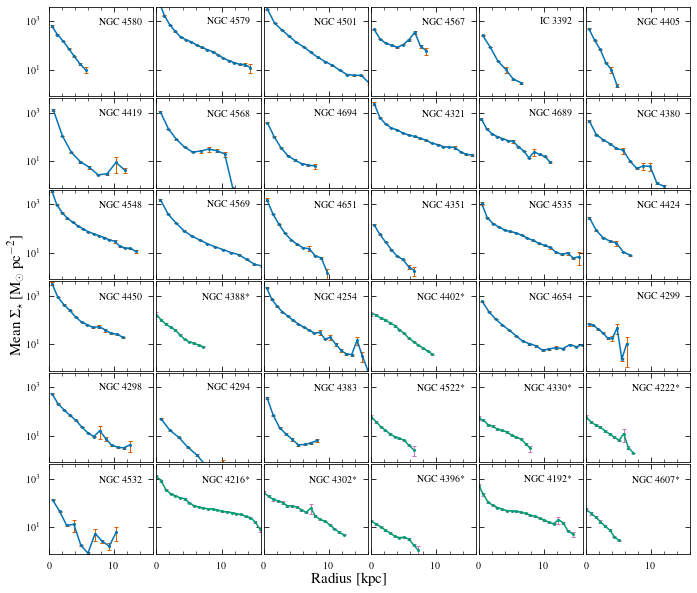

In [11]:
I_THRESHOLD = 80  # degrees
#
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(9.5, 8), sharex=True, sharey=True)
for ax, galname, i in zip(axs.flatten(), galaxies[DECR_MEDIAN_M_DENSITY_IDX], inclinations[DECR_MEDIAN_M_DENSITY_IDX]):
    is_high_i = i >= I_THRESHOLD
    galidx = np.where(GALAXIES == galname)[0]
    if galidx.size != 1:
        raise ValueError(f"More than 1 galaxy matched with name {galname} at indices {galidx}")
    galidx = galidx[0]
    if is_high_i:
        tmp_color = sns.color_palette("colorblind")[2]
        tmp_ecolor = sns.color_palette("colorblind")[4]
    else:
        tmp_color = sns.color_palette("colorblind")[0]
        tmp_ecolor = sns.color_palette("colorblind")[3]
    ebar = ax.errorbar(
        x=radius_kpc[galidx],
        y=radial_profiles[galidx].avg_data,
        yerr=radial_profiles[galidx].avg_data_err,
        fmt="-o",
        markersize=2,
        color=tmp_color,
        ecolor=tmp_ecolor,
        elinewidth=1,
        capsize=2,
    )
    # ax.set_ylim(4e0, 3e3)  # if not using fit until all NaNs file
    ax.set_ylim(8e-1, 4e3)  # if using file where annuli are added until one encounters an all NaN area
    ax.semilogy()
    # ax.set_xlim(0, 11)  # if not using fit until all NaNs file
    ax.set_xlim(0, 16)  # if using file where annuli are added until one encounters an all NaN area
    pu.set_aspect(ax, 0.86, logx=False, logy=True)
    # Galaxy name in top right corner + add space between letters and numbers in galname
    high_i_str = "*" if is_high_i else ""
    ax.text(0.9, 0.8, re.sub(r"(\d+)", " \\1", galname) + high_i_str, c="k", ha="right", transform=ax.transAxes)
    ax.grid(False)

fig.text(0.5, 0.0, "Radius [kpc]", ha="center", fontsize=15)
fig.text(
    0.0,
    0.5,
    f"{avg_function.capitalize()} " + r"$\Sigma_\star$ [$\rm M_\odot\;pc^{-2} $]",
    va="center",
    rotation="vertical",
    fontsize=15,
)
#
plt.subplots_adjust(left=0.06, right=1.0, bottom=0.05, top=1.0, wspace=0.015, hspace=0.02)
# fig.savefig(SIG_STAR_PATH + f"stellar_mass_density_9as_i_corr_NGVS-VERTICO_DecrMedianSigmaStar_noNorm{incl_bad_str}{fit_until_all_nans_str}.pdf")
plt.show()

# Vorbin Stellar Mass Density Radial Profile Mosaic


Plotting NGC4579


Plotting NGC4419


Plotting NGC4501


Plotting NGC4580
Plotting NGC4568


Plotting NGC4567


Plotting NGC4569


Plotting IC3392
Plotting NGC4405


Plotting NGC4694


Plotting NGC4548


Plotting NGC4321


Plotting NGC4380


Plotting NGC4689


Plotting NGC4651


Plotting NGC4402


Plotting NGC4388


Plotting NGC4535


Plotting NGC4254


Plotting NGC4450


Plotting NGC4351


Plotting NGC4654


Plotting NGC4424


Plotting NGC4298


Plotting NGC4299


Plotting NGC4532


Plotting NGC4216


Plotting NGC4294


Plotting NGC4522


Plotting NGC4222


Plotting NGC4192


Plotting NGC4302


Plotting NGC4383


Plotting NGC4330


Plotting NGC4607


Plotting NGC4396


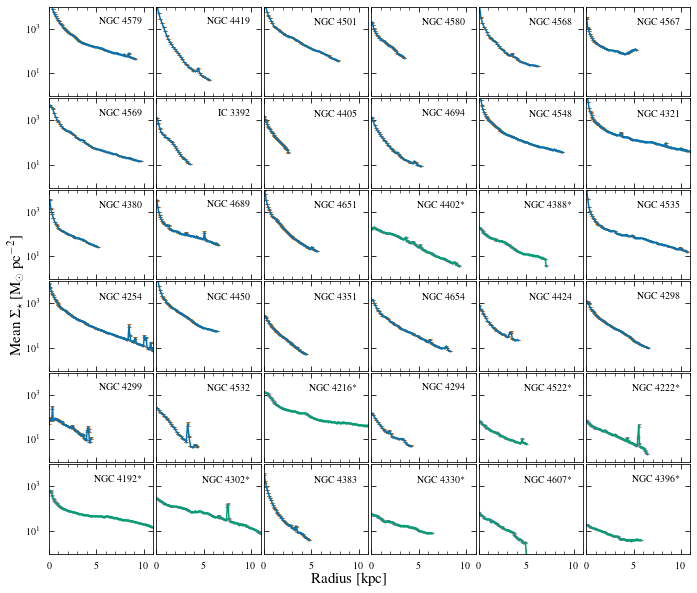

In [9]:
# Set these 3 parameters
USE_SNR_MASK = False  # specifies file to use
I_THRESHOLD = 80  # degrees
ORDER = "Mean"  # "Mean" or "Median". Specifies sort order
#
use_snr_mask_str = "yesSNRmask" if USE_SNR_MASK else "noSNRmask"
if ORDER == "Mean":
    sort_idx = DECR_MEAN_M_DENSITY_IDX
elif ORDER == "Median":
    sort_idx = DECR_MEDIAN_M_DENSITY_IDX
else:
    raise ValueError("ORDER must be 'Mean' or 'Median'")
#
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(9.5, 8), sharex=True, sharey=True)
for ax, galname, i in zip(axs.flatten(), GALAXIES[sort_idx], INCLINATIONS[sort_idx]):
    is_high_i = i >= I_THRESHOLD
    print("Plotting", galname)
    #
    # Load radial profile data
    #
    gal_dir_str = f"/arc/home/IsaacCheng/coop_f2021/galaxies/vorbin_radial_profiles/{galname}/"
    gal_rp_infile = gal_dir_str + f"{galname}_M_density_rps_NGVS-VERTICO_{use_snr_mask_str}_i_corr.pkl"
    with open(gal_rp_infile, "rb") as f:
        file = dill.load(f)
        gal_rp = file["radial_profile"]
        file = None  # free memory
    vorbin_wcs = gal_rp.rp_options["wcs"]
    px_to_kpc = fu.calc_pc_per_px(vorbin_wcs, GALDIST)[0][0] / 1000  # assume square pixels
    #
    if is_high_i:
        tmp_color = sns.color_palette("colorblind")[2]
        tmp_ecolor = sns.color_palette("colorblind")[4]
    else:
        tmp_color = sns.color_palette("colorblind")[0]
        tmp_ecolor = sns.color_palette("colorblind")[3]
    ebar = ax.errorbar(
        x=gal_rp.radii * px_to_kpc,
        y=gal_rp.avg_data,
        yerr=gal_rp.avg_data_err,
        fmt="-o",
        markersize=1,
        color=tmp_color,
        ecolor=tmp_ecolor,
        elinewidth=1,
        capsize=2,
    )
    ax.set_ylim(9e-1, 1e4)
    ax.semilogy()
    ax.set_xlim(0, 11)
    pu.set_aspect(ax, 0.86, logx=False, logy=True)
    # Galaxy name in top right corner + add space between letters and numbers in galname
    high_i_str = "*" if is_high_i else ""
    ax.text(0.9, 0.8, re.sub(r"(\d+)", " \\1", galname) + high_i_str, c="k", ha="right", transform=ax.transAxes)
    ax.grid(False)
    if galname != GALAXIES[sort_idx][-1]:
        gal_rp = None  # free memory
    
avg_function = gal_rp.rp_options["func"]
fig.text(0.5, 0.0, "Radius [kpc]", ha="center", fontsize=15)
fig.text(
    0.0,
    0.5,
    f"{avg_function.capitalize()} " + r"$\Sigma_\star$ [$\rm M_\odot\;pc^{-2} $]",
    va="center",
    rotation="vertical",
    fontsize=15,
)
#
plt.subplots_adjust(left=0.06, right=1.0, bottom=0.05, top=1.0, wspace=0.015, hspace=0.02)
fig.savefig(SIG_STAR_PATH + f"stellar_mass_density_vorbin_SNR50_i_corr_NGVS-VERTICO_Decr{ORDER}SigmaStar_{use_snr_mask_str}.pdf")
plt.show()